In [ ]:
# # ONLY RUN WHEN IN GOOGLE COLAB

# !git clone https://github.com/Vachonni/TrainingNLP.git

# import os
# os.chdir('TrainingNLP')

# !pip install -r requirements_colab.txt
# !pip install -e .

In [1]:
import ast
import nltk
import os
import spacy

import pandas as pd
import scikitplot as skplt

from spacy_lefff import LefffLemmatizer, POSTagger
from spacy.language import Language
from sklearn.metrics import classification_report, accuracy_score, f1_score

import config


# Download the french tokenizer
nltk.download('punkt')

# Need to download the french model first
!python -m spacy download fr_core_news_sm

# Create functions for lemmatisation of French with spaCy
@Language.factory('french_lemmatizer')
def create_french_lemmatizer(nlp, name):
    return LefffLemmatizer(after_melt=True, default=True)
@Language.factory('melt_tagger')  
def create_melt_tagger(nlp, name):
    return POSTagger()

# Print data example with complete content of column 'review'
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to /home/myuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 22.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


# **Consort - Formation NLP**

## Introduction - Analyse de sentiments

Objectif: Déterminer le sentiment d'un texte à l'aide de différentes techniques.

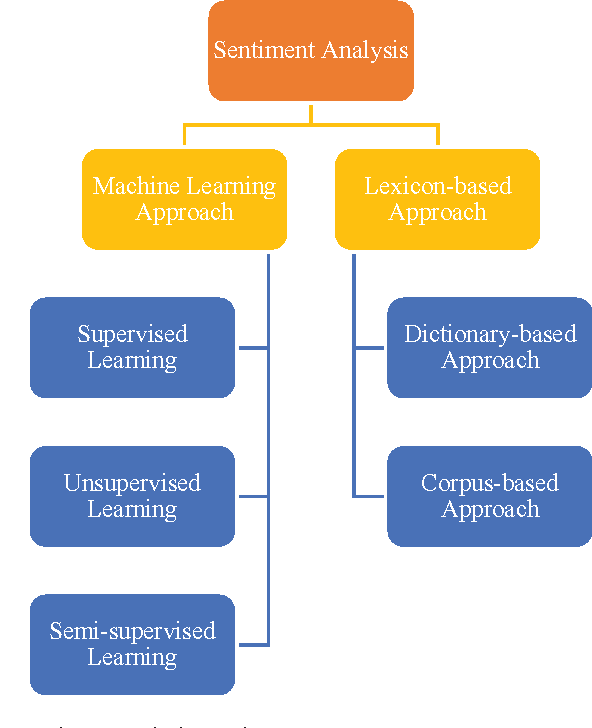






### Approche lexicale 
(*Lexicon or Rule-Based approach*)
  - RegEx
  - NLTK
  - SpaCy

### Machine Learning
  - Modèles à taille fixe
    - Bag of words
  - Modèles réccurents
    - CBOW
  - Modèles transformeurs
    - À affiner (fine-tune)
    - HuggingFace Sentiment Analysis
    - Google's API (sans création de compte)



# Données

Jeu de données pour l'analyse de sentiments: Avis des utilisateurs d'Allociné.fr disponible ici: https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/tree/master/allocine_dataset

Il contient 100 000 avis positifs et 100 000 avis négatifs répartis en 3 répartitions équilibrées : train (160 000 avis), val (20 000) et test (20 000).

**NOTE:** Afin d'optimiser le temps de calcul pour cet exercice, nous allons réduire l'ensemble test 1000. 

# Approche lexicale

1. Un "lexique" de mots avec le sentiment lié à ceux-ci est disponible
2. Pour analyser un texte, extraction de mots présents dans le lexique
3. Calcul du sentiment général et comptant le nombre de mots par sentiment.

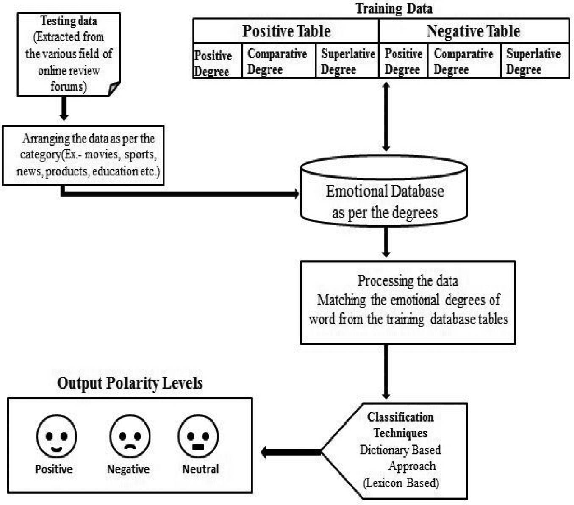


In [2]:
# Load preprocessed test_data 
test_data = pd.read_csv(config.base_dir + '/Data/prepro_test_data.csv')
# Turn list columns back to list
for col in ['token_review', 'stem_review', 'lem_review']:
    test_data[col] = test_data[col].apply(ast.literal_eval)

test_data.head()


,ID,review,polarity,clean_review,token_review,stem_review,lem_review
0,0,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1,magnifique épopée une belle histoire touchante avec des acteurs qui interprètent très bien leur rôles mel gibson heath ledger jason isaacs le genre de film qui se savoure en famille,"[magnifique, épopée, une, belle, histoire, touchante, avec, des, acteurs, qui, interprètent, très, bien, leur, rôles, mel, gibson, heath, ledger, jason, isaacs, le, genre, de, film, qui, se, savoure, en, famille]","[magnif, épop, une, bel, histoir, touch, avec, de, acteur, qui, interprètent, tres, bien, leur, rôl, mel, gibson, heath, ledg, jason, isaac, le, genr, de, film, qui, se, savour, en, famill]","[magnifique, épopée, un, beau, histoire, touchant, avec, un, acteur, qui, interpréter, très, bien, son, rôle, mel, gibson, heath, ledger, jason, isaacs, le, genre, de, film, qui, clr, savourer, en, famille]"
1,1,"Je n'ai pas aimé mais pourtant je lui mets 2 étoiles car l'expérience est louable. Rien de conventionnel ici. Une visite E.T. mais jonchée d'idées /- originales. Le soucis, tout ceci avait-il vraiment sa place dans un film de S.F. tirant sur l'horreur ? Voici un film qui, à l'inverse de tant d'autres qui y ont droit, mériterait peut-être un remake.",0,je n ai pas aimé mais pourtant je lui mets étoiles car l expérience est louable rien de conventionnel ici une visite e t mais jonchée d idées originales le soucis tout ceci avait il vraiment sa place dans un film de s f tirant sur l horreur voici un film qui à l inverse de tant d autres qui y ont droit mériterait peut être un remake,"[je, n, ai, pas, aimé, mais, pourtant, je, lui, mets, étoiles, car, l, expérience, est, louable, rien, de, conventionnel, ici, une, visite, e, t, mais, jonchée, d, idées, originales, le, soucis, tout, ceci, avait, il, vraiment, sa, place, dans, un, film, de, s, f, tirant, sur, l, horreur, voici, un, film, qui, à, l, inverse, de, tant, d, autres, qui, y, ont, droit, mériterait, peut, être, un, remake]","[je, n, ai, pas, aim, mais, pourt, je, lui, met, étoil, car, l, expérient, est, louabl, rien, de, conventionnel, ici, une, visit, e, t, mais, jonch, d, idé, original, le, souc, tout, cec, avait, il, vrai, sa, plac, dan, un, film, de, s, f, tir, sur, l, horreur, voic, un, film, qui, à, l, invers, de, tant, d, autr, qui, y, ont, droit, mérit, peut, être, un, remak]","[je, n, avoir, pas, aimé, mais, pourtant, je, lui, mettre, étoile, car, l, expérience, être, louable, rien, de, conventionnel, ici, un, visite, e, t, mais, jonchée, d, idée, original, le, souci, tout, ceci, avoir, il, vraiment, son, place, dans, un, film, de, s, f, tirant, sur, l, horreur, voici, un, film, qui, à, l, inverse, de, tant, d, autre, qui, y, avoir, droit, mériter, pouvoir, être, un, remake]"
2,2,Un dessin animé qui brille par sa féerie et ses chansons.,1,un dessin animé qui brille par sa féerie et ses chansons,"[un, dessin, animé, qui, brille, par, sa, féerie, et, ses, chansons]","[un, dessin, anim, qui, brill, par, sa, féer, et, se, chanson]","[un, dessin, animé, qui, briller, par, son, féerie, et, son, chanson]"
3,3,"Si c'est là le renouveau du cinéma français, c'est tout de même foutrement chiant. Si l'objet est très stylisé et la tension palpable, le film paraît plutôt creux.",0,si c est là le renouveau du cinéma français c est tout de même foutrement chiant si l objet est très stylisé et la tension palpable le film paraît plutôt creux,"[si, c, est, là, le, renouveau, du, cinéma, français, c, est, tout, de, même, foutrement, chiant, si, l, objet, est, très, stylisé, et, la, tension, palpable, le, film, paraît, plutôt, creux]","[si, c, est, là, le, renouveau, du, cinem, franc, c, est, tout, de, mêm, foutr, chi, si, l, objet, est, tres, stylis, et, la, tension, palpabl, le, film, paraît, plutôt, creux]","[si, c, être, là, 

## Lexique

Lexique français des mots positifs et négatis obtenus ici: https://www.kaggle.com/datasets/rtatman/sentiment-lexicons-for-81-languages

In [3]:
# Load lexicon txt file with pandas
lex_pos = pd.read_csv(config.base_dir + '/Data/positive_words_fr.txt', header=None)
lex_pos.columns = ['token_positive']
lex_neg = pd.read_csv(config.base_dir + '/Data/negative_words_fr.txt', header=None)
lex_neg.columns = ['token_negative']

In [4]:
# Get NLTK stemmer for French language
stemmer = nltk.stem.snowball.FrenchStemmer()
# Lemmatization for French language with functions created above
nlp = spacy.load('fr_core_news_sm')
nlp.add_pipe('melt_tagger', after='parser')
nlp.add_pipe('french_lemmatizer', after='melt_tagger')


# Create steemed versions of the lexicon
lex_pos['stem_positive'] = lex_pos['token_positive'].apply(lambda x: stemmer.stem(x))
lex_neg['stem_negative'] = lex_neg['token_negative'].apply(lambda x: stemmer.stem(x))
# Create lemmatised versions of the lexicon
lex_pos['lem_positive'] = lex_pos['token_positive'].apply(lambda x: nlp(x)[0]._.lefff_lemma)
lex_neg['lem_negative'] = lex_neg['token_negative'].apply(lambda x: nlp(x)[0]._.lefff_lemma)

lex = pd.concat([lex_pos, lex_neg], axis=1)
lex.head(10)

,token_positive,stem_positive,lem_positive,token_negative,stem_negative,lem_negative
0,plus,plus,plus,sur,sur,sur
1,comme,comm,comme,très,tres,très
2,premier,premi,premier,tout,tout,tout
3,bien,bien,bien,contre,contr,contre
4,groupe,group,groupe,faire,fair,faire
5,sans,san,sans,temps,temp,temps
6,fin,fin,fin,mort,mort,mort
7,non,non,non,peu,peu,peu
8,notamment,not,notamment,part,part,part
9,grand,grand,grand,reste,rest,rester


## Predictions 

L'idée est de compter, pour chaque commentaire, le nombre de mots positifs et le nombre de mots négatifs. 

Le plus grand des deux détermine le sentiment prédit pour le commentaire. 

token_START
token_pos
token_neg
token_diff
token_pred
token_confusion

Classification Report : token_
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       516
           1       0.63      0.66      0.64       484

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000

token_report
stem_START
stem_pos
stem_neg
stem_diff
stem_pred
stem_confusion

Classification Report : stem_
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       516
           1       0.67      0.52      0.59       484

    accuracy                           0.65      1000
   macro avg       0.65      0.64      0.64      1000
weighted avg       0.65      0.65      0.64      1000

stem_report
lem_START
lem_pos
lem_neg
lem_diff
lem_pred
lem_confusion

Classification Report : lem_
              precision    recall  f

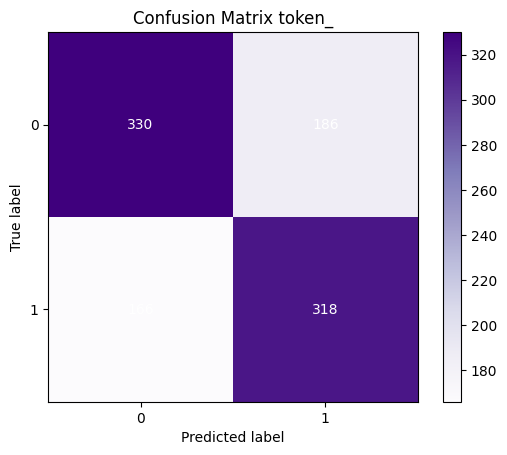

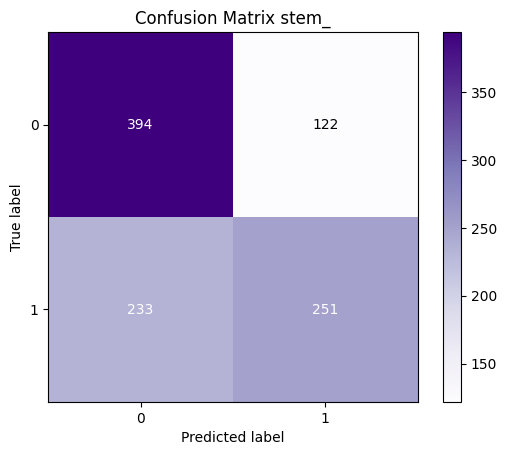

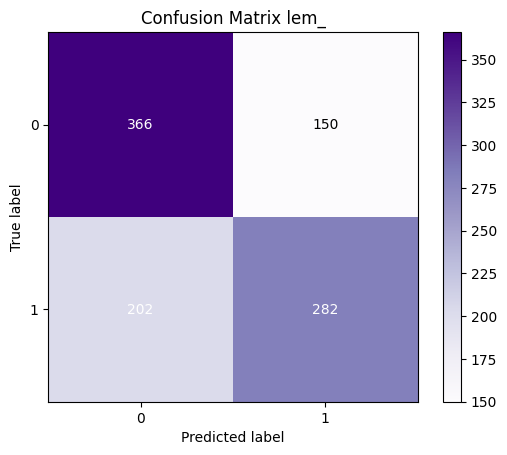

In [5]:
# Make predictions and evaluate the 3 different techniques
for tech in ['token_', 'stem_', 'lem_']:
    # Predictions
    print(tech+"START")
    test_data[tech+'pos'] = test_data[tech+'review'].apply(lambda l: [w for w in l if w in lex[tech+'positive'].dropna().values])
    print(tech+"pos")
    test_data[tech+'neg'] = test_data[tech+'review'].apply(lambda l: [w for w in l if w in lex[tech+'negative'].values])
    print(tech+"neg")
    test_data[tech+'diff'] = test_data[tech+'pos'].apply(len) - test_data[tech+'neg'].apply(len)
    print(tech+"diff")
    test_data[tech+'pred'] = test_data[tech+'diff'] >= 0
    print(tech+"pred")
    # Plot confusion matrix
    skplt.metrics.plot_confusion_matrix(test_data['polarity'], test_data[tech+'pred'],
                                    title="Confusion Matrix "+tech,
                                    cmap="Purples",
                                    )
    print(tech+"confusion")
    # Print classification report
    print('\nClassification Report : '+tech)
    print(classification_report(test_data['polarity'], test_data[tech+'pred']))
    print(tech+"report")
    

## Analyse

Importance de la liste de mots...
Importance du threshold... 


L'utilisation de dictionnaires est probablement le moyen le plus simple d'effectuer cette analyse des sentiments. Cependant, il échoue encore souvent à gérer toutes les complexités du langage.

Par exemple, considérons une phrase simple comme "il fait très chaud". Il n'exprime aucun sentiment en soi. Néanmoins, on peut le considérer comme négatif lorsqu'on parle d'un ordinateur portable, et positif lorsqu'on parle d'un réchaud.

De plus, ces systèmes doivent gérer correctement les négations et autres variations de langage qui peuvent modifier le sentiment des mots autrement pris isolément.

Enfin et surtout, le texte peut souvent contenir du sarcasme qui est vraiment difficile à détecter automatiquement et peut fausser les résultats d'un algorithme d'analyse des sentiments.

Sur la base de ces considérations, si des données de formation sont disponibles, il est généralement plus souhaitable d'utiliser une approche basée sur l'apprentissage automatique, qui surpasse souvent les méthodes basées sur un dictionnaire.

## Save results

### By example

In [6]:
pred_test_data = test_data[['ID', 'review', 'polarity', 'token_pred', 'stem_pred', 'lem_pred']]

# Turn bool in int
pred_test_data.loc[:,'token_pred'] = pred_test_data['token_pred'].astype(int)
pred_test_data.loc[:,'stem_pred'] = pred_test_data['stem_pred'].astype(int)
pred_test_data.loc[:,'lem_pred'] = pred_test_data['lem_pred'].astype(int)

# Save predictions
pred_test_data.to_csv(config.base_dir + '/Data/pred_test_data.csv', index=False)

pred_test_data.head()

,ID,review,polarity,token_pred,stem_pred,lem_pred
0,0,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1,1,1,1
1,1,"Je n'ai pas aimé mais pourtant je lui mets 2 étoiles car l'expérience est louable. Rien de conventionnel ici. Une visite E.T. mais jonchée d'idées /- originales. Le soucis, tout ceci avait-il vraiment sa place dans un film de S.F. tirant sur l'horreur ? Voici un film qui, à l'inverse de tant d'autres qui y ont droit, mériterait peut-être un remake.",0,0,0,0
2,2,Un dessin animé qui brille par sa féerie et ses chansons.,1,1,1,1
3,3,"Si c'est là le renouveau du cinéma français, c'est tout de même foutrement chiant. Si l'objet est très stylisé et la tension palpable, le film paraît plutôt creux.",0,0,0,0
4,4,"Et pourtant on s’en Doutait !Second volet très mauvais, sans fraîcheur et particulièrement lourdingue. Quel dommage.",0,0,0,0


### Comparaison analysis

In [7]:
# For the 3 different techniques, calculate the accuracy and F1 score
accuracy = []
f1 = []
for tech in ['token_', 'stem_', 'lem_']:
    accuracy.append(accuracy_score(test_data['polarity'], test_data[tech+'pred']))
    f1.append(f1_score(test_data['polarity'], test_data[tech+'pred'], average='micro'))

df_comparsion = pd.DataFrame({'accuracy': accuracy, 'f1': f1}, index=['lexi_token', 'lexi_stem', 'lexi_lem'])
df_comparsion.sort_values('accuracy', ascending=False, inplace=True)

df_comparsion


,accuracy,f1
lexi_token,0.648,0.648
lexi_lem,0.648,0.648
lexi_stem,0.645,0.645


In [9]:
# Check if comparsion_analysis.csv already exists 
if os.path.exists(config.base_dir + '/Data/comparsion_analysis.csv'):
    # If yes, read it and update it with the new results
    df_comparsion_old = pd.read_csv(config.base_dir + '/Data/comparsion_analysis.csv', index_col=0)
    print(df_comparsion_old)
    df_comparsion_old.update(df_comparsion)
    df_comparsion_combined = pd.concat([df_comparsion_old, df_comparsion[~df_comparsion.index.isin(df_comparsion_old.index)]])
    df_comparsion_combined.sort_values('accuracy', ascending=False, inplace=True)
    # Save the updated DataFrame back to the CSV file
    df_comparsion_combined.to_csv(config.base_dir + '/Data/comparsion_analysis.csv')
    print(df_comparsion_combined)
else:
    df_comparsion.to_csv(config.base_dir + '/Data/comparsion_analysis.csv', index=True)

            accuracy     f1
lexi_token     0.648  0.648
lexi_lem       0.648  0.648
lexi_stem      0.645  0.645
            accuracy     f1
lexi_token     0.648  0.648
lexi_lem       0.648  0.648
lexi_stem      0.645  0.645
